## Klasyfikacja chorób roślin
W niniejszym notebooku zbudowałam model sieci konwolucyjnej służący do klasyfikacji chorób roślin na podstawie zbioru plants_dataset z wykorzystaniem pakietu Keras. Wytrenowany model na podstawie zdjęcia zawierającego liść pewnej rośliny określi do jakiej rośliny należy i na jaką chorobę ta roślina choruje (bądź stwierdzi, że roślina jest zdrowa).
Jako metrykę sukcesu przyjęłam accuracy.

In [1]:
import numpy as np
import pandas as pd

import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

from os import mkdir, listdir
from shutil import rmtree, copyfile
import random

### Przygotowanie danych
W celu umożliwienia ewaluacji modelu podzieliłam dostępny zbiór danych plants_dataset na zbiory treningowy (70% wszystkich danych), walidacyjny (20%) i testowy (10%). Należy zwrócić uwagę na to, że klasy nie są zbilansowane, np. w jednej klasie mamy ponad 5000 zdjęć, a w innej ok. 200 zdjęć. Kod w poniższej komórce dokonuje podziału na zbiory train, val i test z zachowaniem oryginalnego rozkładu zdjęć między poszczególnymi klasami.

In [9]:
basePath = "plants_2/plants_dataset"
dataClasses = listdir(basePath)

%time
resultPath = "plants_2/plants_dataset_2"
resultMap = {"train": 0.7, "val": 0.2, "test": 0.1}

#rmtree(resultPath, True)

mkdir(resultPath)
for k, v in resultMap.items():
    dirPath = "{}/{}".format(resultPath, k)
    mkdir(dirPath)

for d in dataClasses:
    dirPath = "{}/{}".format(basePath, d)
    dataClassesFiles = listdir(dirPath)
    dataClassesLen = len(dataClassesFiles)
    np.random.seed(0)
    np.random.shuffle(dataClassesFiles)

    for k, v in resultMap.items():
        dirPath = "{}/{}/{}".format(resultPath, k, d)
        mkdir(dirPath)
        for i in range(int(v * dataClassesLen)):
            fileName = dataClassesFiles.pop()
            src = "{}/{}/{}".format(basePath, d, fileName)
            dst = "{}/{}/{}/{}".format(resultPath, k, d, fileName)
            copyfile(src, dst)
            print(src + " " + dst + "| ", end="")

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 24.3 µs


plants_2/plants_dataset/Corn_(maize)___Northern_Leaf_Blight/29d09796-3790-450a-97cc-ba6db0cf368f___RS_NLB 3487.JPG plants_2/plants_dataset_2/train/Corn_(maize)___Northern_Leaf_Blight/29d09796-3790-450a-97cc-ba6db0cf368f___RS_NLB 3487.JPG| plants_2/plants_dataset/Corn_(maize)___Northern_Leaf_Blight/1ca58163-0570-48af-bdef-2fd3a751dc0a___RS_NLB 3927.JPG plants_2/plants_dataset_2/train/Corn_(maize)___Northern_Leaf_Blight/1ca58163-0570-48af-bdef-2fd3a751dc0a___RS_NLB 3927.JPG| plants_2/plants_dataset/Corn_(maize)___Northern_Leaf_Blight/0be917c7-7340-40f3-af7f-3343a45d7621___RS_NLB 3942 copy.jpg plants_2/plants_dataset_2/train/Corn_(maize)___Northern_Leaf_Blight/0be917c7-7340-40f3-af7f-3343a45d7621___RS_NLB 3942 copy.jpg| plants_2/plants_dataset/Corn_(maize)___Northern_Leaf_Blight/bce0336e-2867-4e62-8169-145bc711cba4___RS_NLB 3878.JPG plants_2/plants_dataset_2/train/Corn_(maize)___Northern_Leaf_Blight/bce0336e-2867-4e62-8169-145bc711cba4___RS_NLB 3878.JPG| plants_2/plants_dataset/Corn_(maiz

plants_2/plants_dataset/Soybean___healthy/ce987b6f-f906-4537-ba2b-79d732e2910e___RS_HL 7428.JPG plants_2/plants_dataset_2/train/Soybean___healthy/ce987b6f-f906-4537-ba2b-79d732e2910e___RS_HL 7428.JPG| plants_2/plants_dataset/Soybean___healthy/fd7d0d1b-7f3d-4fb9-8f3c-959595e1ece5___RS_HL 5711 1.JPG plants_2/plants_dataset_2/train/Soybean___healthy/fd7d0d1b-7f3d-4fb9-8f3c-959595e1ece5___RS_HL 5711 1.JPG| plants_2/plants_dataset/Soybean___healthy/e954dfad-27a6-4a0d-8889-833202ff07a7___RS_HL 7125.JPG plants_2/plants_dataset_2/train/Soybean___healthy/e954dfad-27a6-4a0d-8889-833202ff07a7___RS_HL 7125.JPG| plants_2/plants_dataset/Soybean___healthy/41849ab5-a005-4f73-9f7c-9aac708e97a0___RS_HL 2855.JPG plants_2/plants_dataset_2/train/Soybean___healthy/41849ab5-a005-4f73-9f7c-9aac708e97a0___RS_HL 2855.JPG| plants_2/plants_dataset/Soybean___healthy/a3dc30fb-6224-45e9-a31f-92b767761c5e___RS_HL 3109.JPG plants_2/plants_dataset_2/train/Soybean___healthy/a3dc30fb-6224-45e9-a31f-92b767761c5e___RS_HL 3

plants_2/plants_dataset/Soybean___healthy/bbdc4df4-9179-4d87-be14-ecd14c0f70d7___RS_HL 4173.JPG plants_2/plants_dataset_2/test/Soybean___healthy/bbdc4df4-9179-4d87-be14-ecd14c0f70d7___RS_HL 4173.JPG| plants_2/plants_dataset/Soybean___healthy/e3f5fee2-96b5-4cec-8239-c8433cf0048e___RS_HL 6759.JPG plants_2/plants_dataset_2/test/Soybean___healthy/e3f5fee2-96b5-4cec-8239-c8433cf0048e___RS_HL 6759.JPG| plants_2/plants_dataset/Soybean___healthy/89ed5130-7fad-4509-957a-68eea572cb1d___RS_HL 2812.JPG plants_2/plants_dataset_2/test/Soybean___healthy/89ed5130-7fad-4509-957a-68eea572cb1d___RS_HL 2812.JPG| plants_2/plants_dataset/Soybean___healthy/b7675e8a-cbdc-4a88-ba95-235b7433f21c___RS_HL 7381.JPG plants_2/plants_dataset_2/test/Soybean___healthy/b7675e8a-cbdc-4a88-ba95-235b7433f21c___RS_HL 7381.JPG| plants_2/plants_dataset/Soybean___healthy/e71304ae-821c-4a2c-8d5c-024e80141720___RS_HL 3486.JPG plants_2/plants_dataset_2/test/Soybean___healthy/e71304ae-821c-4a2c-8d5c-024e80141720___RS_HL 3486.JPG| 

plants_2/plants_dataset/Cherry_(including_sour)___healthy/d9ffa906-ca86-4a23-bf43-033c6270e05f___JR_HL 4280.JPG plants_2/plants_dataset_2/train/Cherry_(including_sour)___healthy/d9ffa906-ca86-4a23-bf43-033c6270e05f___JR_HL 4280.JPG| plants_2/plants_dataset/Cherry_(including_sour)___healthy/162dc895-00e6-4f02-ab49-a7030ec8984d___JR_HL 9445.JPG plants_2/plants_dataset_2/train/Cherry_(including_sour)___healthy/162dc895-00e6-4f02-ab49-a7030ec8984d___JR_HL 9445.JPG| plants_2/plants_dataset/Cherry_(including_sour)___healthy/f21585ad-cdf1-49ac-8290-19d93653370d___JR_HL 9670.JPG plants_2/plants_dataset_2/train/Cherry_(including_sour)___healthy/f21585ad-cdf1-49ac-8290-19d93653370d___JR_HL 9670.JPG| plants_2/plants_dataset/Cherry_(including_sour)___healthy/eaf3b9b2-6372-4333-b1ff-297485cd3656___JR_HL 9565.JPG plants_2/plants_dataset_2/train/Cherry_(including_sour)___healthy/eaf3b9b2-6372-4333-b1ff-297485cd3656___JR_HL 9565.JPG| plants_2/plants_dataset/Cherry_(including_sour)___healthy/2cf85c16-5

plants_2/plants_dataset/Tomato___Early_blight/93533fec-94de-411f-a52e-38cd4d36dbee___RS_Erly.B 9558.JPG plants_2/plants_dataset_2/val/Tomato___Early_blight/93533fec-94de-411f-a52e-38cd4d36dbee___RS_Erly.B 9558.JPG| plants_2/plants_dataset/Tomato___Early_blight/757b49d0-db8e-4352-820a-9f0bdb7d2657___RS_Erly.B 7748.JPG plants_2/plants_dataset_2/val/Tomato___Early_blight/757b49d0-db8e-4352-820a-9f0bdb7d2657___RS_Erly.B 7748.JPG| plants_2/plants_dataset/Tomato___Early_blight/eaf0d111-089a-4808-a34c-dd40e3bb4db4___RS_Erly.B 8393.JPG plants_2/plants_dataset_2/val/Tomato___Early_blight/eaf0d111-089a-4808-a34c-dd40e3bb4db4___RS_Erly.B 8393.JPG| plants_2/plants_dataset/Tomato___Early_blight/0cd17aff-13d8-439a-ac08-dae1aea55edb___RS_Erly.B 7828.JPG plants_2/plants_dataset_2/val/Tomato___Early_blight/0cd17aff-13d8-439a-ac08-dae1aea55edb___RS_Erly.B 7828.JPG| plants_2/plants_dataset/Tomato___Early_blight/0e2abcfb-e62b-4c61-a24a-0800cad904a8___RS_Erly.B 7382.JPG plants_2/plants_dataset_2/val/Tomato

plants_2/plants_dataset/Tomato___Late_blight/a06cd325-69d3-476c-a515-7e836bb39f3a___RS_Late.B 7126.JPG plants_2/plants_dataset_2/train/Tomato___Late_blight/a06cd325-69d3-476c-a515-7e836bb39f3a___RS_Late.B 7126.JPG| plants_2/plants_dataset/Tomato___Late_blight/1546f916-115c-42dc-90c7-ff8d53c4273f___RS_Late.B 4836.JPG plants_2/plants_dataset_2/train/Tomato___Late_blight/1546f916-115c-42dc-90c7-ff8d53c4273f___RS_Late.B 4836.JPG| plants_2/plants_dataset/Tomato___Late_blight/784f6313-1080-4bd1-a556-d4e14e6879d0___GHLB_PS Leaf 53.1 Day 18 .jpg plants_2/plants_dataset_2/train/Tomato___Late_blight/784f6313-1080-4bd1-a556-d4e14e6879d0___GHLB_PS Leaf 53.1 Day 18 .jpg| plants_2/plants_dataset/Tomato___Late_blight/928b2917-6b5b-4752-859f-61d6ca57f976___GHLB2 Leaf 9070.JPG plants_2/plants_dataset_2/train/Tomato___Late_blight/928b2917-6b5b-4752-859f-61d6ca57f976___GHLB2 Leaf 9070.JPG| plants_2/plants_dataset/Tomato___Late_blight/e1d00dcb-f2cb-41ca-8a45-a46c43e7c90e___GHLB2 Leaf 8697.JPG plants_2/pla

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



plants_2/plants_dataset/Peach___healthy/afe0938a-0d13-4fef-b121-ffe3f655ec84___Rutg._HL 3598.JPG plants_2/plants_dataset_2/val/Peach___healthy/afe0938a-0d13-4fef-b121-ffe3f655ec84___Rutg._HL 3598.JPG| plants_2/plants_dataset/Peach___healthy/c0fa787f-dee0-42a0-a51a-2e7fb36fcdc8___Rutg._HL 3628.JPG plants_2/plants_dataset_2/val/Peach___healthy/c0fa787f-dee0-42a0-a51a-2e7fb36fcdc8___Rutg._HL 3628.JPG| plants_2/plants_dataset/Peach___healthy/f934836b-4a43-4970-968e-e0e3c000d448___Rutg._HL 2488.JPG plants_2/plants_dataset_2/val/Peach___healthy/f934836b-4a43-4970-968e-e0e3c000d448___Rutg._HL 2488.JPG| plants_2/plants_dataset/Peach___healthy/5fac87db-e0f9-43a5-9704-60ae7689b56e___Rutg._HL 3751.JPG plants_2/plants_dataset_2/val/Peach___healthy/5fac87db-e0f9-43a5-9704-60ae7689b56e___Rutg._HL 3751.JPG| plants_2/plants_dataset/Peach___healthy/518e3718-bc67-4fd5-afc5-696ddc96233d___Rutg._HL 3626.JPG plants_2/plants_dataset_2/val/Peach___healthy/518e3718-bc67-4fd5-afc5-696ddc96233d___Rutg._HL 3626.

plants_2/plants_dataset/Peach___Bacterial_spot/71e9ae8b-dc19-46ab-9f64-9a4401c3f489___Rut._Bact.S 1354.JPG plants_2/plants_dataset_2/train/Peach___Bacterial_spot/71e9ae8b-dc19-46ab-9f64-9a4401c3f489___Rut._Bact.S 1354.JPG| plants_2/plants_dataset/Peach___Bacterial_spot/6376eca9-564e-46db-9243-60dee73a6e35___Rutg._Bact.S 1334.JPG plants_2/plants_dataset_2/train/Peach___Bacterial_spot/6376eca9-564e-46db-9243-60dee73a6e35___Rutg._Bact.S 1334.JPG| plants_2/plants_dataset/Peach___Bacterial_spot/5f21ae40-4d6e-45d4-8234-294c5c1344ee___Rutg._Bact.S 1667.JPG plants_2/plants_dataset_2/train/Peach___Bacterial_spot/5f21ae40-4d6e-45d4-8234-294c5c1344ee___Rutg._Bact.S 1667.JPG| plants_2/plants_dataset/Peach___Bacterial_spot/03eb7f6a-6a2f-4584-b6e1-03e765b863d1___Rut._Bact.S 1449.JPG plants_2/plants_dataset_2/train/Peach___Bacterial_spot/03eb7f6a-6a2f-4584-b6e1-03e765b863d1___Rut._Bact.S 1449.JPG| plants_2/plants_dataset/Peach___Bacterial_spot/ff997ef8-ae82-422b-8745-fa0d45ce9ada___Rutg._Bact.S 2000.

plants_2/plants_dataset/Squash___Powdery_mildew/c82b184a-0f5a-4be8-927e-4c6627c4f07d___MD_Powd.M 0996.JPG plants_2/plants_dataset_2/train/Squash___Powdery_mildew/c82b184a-0f5a-4be8-927e-4c6627c4f07d___MD_Powd.M 0996.JPG| plants_2/plants_dataset/Squash___Powdery_mildew/50fd0706-d009-415f-af6a-e5210fd3654d___UMD_Powd.M 0321.JPG plants_2/plants_dataset_2/train/Squash___Powdery_mildew/50fd0706-d009-415f-af6a-e5210fd3654d___UMD_Powd.M 0321.JPG| plants_2/plants_dataset/Squash___Powdery_mildew/c9e9d2ea-8c4d-47f8-a65c-036534a7c64b___MD_Powd.M 0512.JPG plants_2/plants_dataset_2/train/Squash___Powdery_mildew/c9e9d2ea-8c4d-47f8-a65c-036534a7c64b___MD_Powd.M 0512.JPG| plants_2/plants_dataset/Squash___Powdery_mildew/de8c8a94-2575-4f87-b736-556b04667719___UMD_Powd.M 0041.JPG plants_2/plants_dataset_2/train/Squash___Powdery_mildew/de8c8a94-2575-4f87-b736-556b04667719___UMD_Powd.M 0041.JPG| plants_2/plants_dataset/Squash___Powdery_mildew/d0e6a452-8114-45da-8790-f1f03ebe109d___MD_Powd.M 0354.JPG plants

plants_2/plants_dataset/Squash___Powdery_mildew/bb76d9b8-760f-4178-b0e0-0d4772c5f709___UMD_Powd.M 0726.JPG plants_2/plants_dataset_2/val/Squash___Powdery_mildew/bb76d9b8-760f-4178-b0e0-0d4772c5f709___UMD_Powd.M 0726.JPG| plants_2/plants_dataset/Squash___Powdery_mildew/7aaf9a49-4419-49b1-b2da-1028bada29b7___MD_Powd.M 0501.JPG plants_2/plants_dataset_2/val/Squash___Powdery_mildew/7aaf9a49-4419-49b1-b2da-1028bada29b7___MD_Powd.M 0501.JPG| plants_2/plants_dataset/Squash___Powdery_mildew/6d42cc7d-a48f-44f8-be4a-fb60ee4610ac___UMD_Powd.M 0181.JPG plants_2/plants_dataset_2/val/Squash___Powdery_mildew/6d42cc7d-a48f-44f8-be4a-fb60ee4610ac___UMD_Powd.M 0181.JPG| plants_2/plants_dataset/Squash___Powdery_mildew/3d61e453-b5de-4973-ae59-53b4c1d2b8fe___UMD_Powd.M 0512.JPG plants_2/plants_dataset_2/val/Squash___Powdery_mildew/3d61e453-b5de-4973-ae59-53b4c1d2b8fe___UMD_Powd.M 0512.JPG| plants_2/plants_dataset/Squash___Powdery_mildew/528d1dbd-1afb-479d-a68f-a1bebef48035___UMD_Powd.M 0107.JPG plants_2/pl

plants_2/plants_dataset/Tomato___Bacterial_spot/ac099bdd-1fb0-4f9c-bb62-be3994736868___UF.GRC_BS_Lab Leaf 0419.JPG plants_2/plants_dataset_2/train/Tomato___Bacterial_spot/ac099bdd-1fb0-4f9c-bb62-be3994736868___UF.GRC_BS_Lab Leaf 0419.JPG| plants_2/plants_dataset/Tomato___Bacterial_spot/f8d0bd35-6d9b-4228-b1a0-d47e1ce3ec5f___GCREC_Bact.Sp 5624.JPG plants_2/plants_dataset_2/train/Tomato___Bacterial_spot/f8d0bd35-6d9b-4228-b1a0-d47e1ce3ec5f___GCREC_Bact.Sp 5624.JPG| plants_2/plants_dataset/Tomato___Bacterial_spot/07de82e1-7258-4c8d-a595-cb2334f02fb4___UF.GRC_BS_Lab Leaf 0418.JPG plants_2/plants_dataset_2/train/Tomato___Bacterial_spot/07de82e1-7258-4c8d-a595-cb2334f02fb4___UF.GRC_BS_Lab Leaf 0418.JPG| plants_2/plants_dataset/Tomato___Bacterial_spot/ea4ddb4b-216a-4ec2-85bc-06314c7de145___GCREC_Bact.Sp 3022.JPG plants_2/plants_dataset_2/train/Tomato___Bacterial_spot/ea4ddb4b-216a-4ec2-85bc-06314c7de145___GCREC_Bact.Sp 3022.JPG| plants_2/plants_dataset/Tomato___Bacterial_spot/e8e7edd6-4791-41

plants_2/plants_dataset/Raspberry___healthy/368f3c83-5bd2-4906-b418-57b6ceff9bfe___Mary_HL 9160.JPG plants_2/plants_dataset_2/val/Raspberry___healthy/368f3c83-5bd2-4906-b418-57b6ceff9bfe___Mary_HL 9160.JPG| plants_2/plants_dataset/Raspberry___healthy/6567ce17-0930-47f8-bec7-7e81b5dcb489___Mary_HL 9220.JPG plants_2/plants_dataset_2/val/Raspberry___healthy/6567ce17-0930-47f8-bec7-7e81b5dcb489___Mary_HL 9220.JPG| plants_2/plants_dataset/Raspberry___healthy/ae5a17be-bbf6-47dd-a04d-7fdaa7703a74___Mary_HL 9324.JPG plants_2/plants_dataset_2/val/Raspberry___healthy/ae5a17be-bbf6-47dd-a04d-7fdaa7703a74___Mary_HL 9324.JPG| plants_2/plants_dataset/Raspberry___healthy/2c4cea4a-66cc-49c5-9c8c-2a641e52eb61___Mary_HL 9212.JPG plants_2/plants_dataset_2/val/Raspberry___healthy/2c4cea4a-66cc-49c5-9c8c-2a641e52eb61___Mary_HL 9212.JPG| plants_2/plants_dataset/Raspberry___healthy/7a064f8d-66cf-42f8-8e70-567c61d027aa___Mary_HL 6392.JPG plants_2/plants_dataset_2/val/Raspberry___healthy/7a064f8d-66cf-42f8-8e7

plants_2/plants_dataset/Tomato___Tomato_Yellow_Leaf_Curl_Virus/21fb518f-e625-4a5c-b75e-b0749ab1ce1f___YLCV_NREC 2451.JPG plants_2/plants_dataset_2/train/Tomato___Tomato_Yellow_Leaf_Curl_Virus/21fb518f-e625-4a5c-b75e-b0749ab1ce1f___YLCV_NREC 2451.JPG| plants_2/plants_dataset/Tomato___Tomato_Yellow_Leaf_Curl_Virus/f098bfc4-7253-4790-a572-3cb059748089___UF.GRC_YLCV_Lab 03240.JPG plants_2/plants_dataset_2/train/Tomato___Tomato_Yellow_Leaf_Curl_Virus/f098bfc4-7253-4790-a572-3cb059748089___UF.GRC_YLCV_Lab 03240.JPG| plants_2/plants_dataset/Tomato___Tomato_Yellow_Leaf_Curl_Virus/60e47250-be41-4c81-b910-6e1696282e91___YLCV_NREC 2123.JPG plants_2/plants_dataset_2/train/Tomato___Tomato_Yellow_Leaf_Curl_Virus/60e47250-be41-4c81-b910-6e1696282e91___YLCV_NREC 2123.JPG| plants_2/plants_dataset/Tomato___Tomato_Yellow_Leaf_Curl_Virus/cd6064b4-5e4f-4350-a04f-0ca6341c2009___UF.GRC_YLCV_Lab 08587.JPG plants_2/plants_dataset_2/train/Tomato___Tomato_Yellow_Leaf_Curl_Virus/cd6064b4-5e4f-4350-a04f-0ca6341c20

plants_2/plants_dataset/Tomato___Tomato_Yellow_Leaf_Curl_Virus/3c882bf7-eeec-4910-a7bc-e59eb7ff41e7___YLCV_GCREC 2211.JPG plants_2/plants_dataset_2/train/Tomato___Tomato_Yellow_Leaf_Curl_Virus/3c882bf7-eeec-4910-a7bc-e59eb7ff41e7___YLCV_GCREC 2211.JPG| plants_2/plants_dataset/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6343c9b3-a054-4d73-912d-97c7f9a9ee83___UF.GRC_YLCV_Lab 02018.JPG plants_2/plants_dataset_2/train/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6343c9b3-a054-4d73-912d-97c7f9a9ee83___UF.GRC_YLCV_Lab 02018.JPG| plants_2/plants_dataset/Tomato___Tomato_Yellow_Leaf_Curl_Virus/0b33ec9a-3f2e-4fee-b663-472c143e3951___YLCV_GCREC 2631.JPG plants_2/plants_dataset_2/train/Tomato___Tomato_Yellow_Leaf_Curl_Virus/0b33ec9a-3f2e-4fee-b663-472c143e3951___YLCV_GCREC 2631.JPG| plants_2/plants_dataset/Tomato___Tomato_Yellow_Leaf_Curl_Virus/1bea01a0-c680-4f6b-9b59-56386acb2d7d___YLCV_NREC 2796.JPG plants_2/plants_dataset_2/train/Tomato___Tomato_Yellow_Leaf_Curl_Virus/1bea01a0-c680-4f6b-9b59-56386acb2d7d_

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



plants_2/plants_dataset/Tomato___healthy/cd8d1ae6-2c8e-43ac-8314-77d88e1153c7___GH_HL Leaf 365.JPG plants_2/plants_dataset_2/val/Tomato___healthy/cd8d1ae6-2c8e-43ac-8314-77d88e1153c7___GH_HL Leaf 365.JPG| plants_2/plants_dataset/Tomato___healthy/bc339a85-6c4e-428a-a18e-9174acdcab1e___RS_HL 0513.JPG plants_2/plants_dataset_2/val/Tomato___healthy/bc339a85-6c4e-428a-a18e-9174acdcab1e___RS_HL 0513.JPG| plants_2/plants_dataset/Tomato___healthy/3211fc4b-c216-46c3-9db7-b340684066b2___RS_HL 0360.JPG plants_2/plants_dataset_2/val/Tomato___healthy/3211fc4b-c216-46c3-9db7-b340684066b2___RS_HL 0360.JPG| plants_2/plants_dataset/Tomato___healthy/1a939012-5b9b-4dfa-aeda-ba97ec857903___GH_HL Leaf 278.JPG plants_2/plants_dataset_2/val/Tomato___healthy/1a939012-5b9b-4dfa-aeda-ba97ec857903___GH_HL Leaf 278.JPG| plants_2/plants_dataset/Tomato___healthy/911f4e0f-c13a-411a-8a75-2793b006a5d4___RS_HL 0083.JPG plants_2/plants_dataset_2/val/Tomato___healthy/911f4e0f-c13a-411a-8a75-2793b006a5d4___RS_HL 0083.JPG|

plants_2/plants_dataset/Apple___Cedar_apple_rust/4fe22d35-3e93-414a-83fc-1be230cec721___FREC_C.Rust 4424.JPG plants_2/plants_dataset_2/train/Apple___Cedar_apple_rust/4fe22d35-3e93-414a-83fc-1be230cec721___FREC_C.Rust 4424.JPG| plants_2/plants_dataset/Apple___Cedar_apple_rust/9ebff92f-999c-49d0-9235-6c98aaa63bbd___FREC_C.Rust 4206.JPG plants_2/plants_dataset_2/train/Apple___Cedar_apple_rust/9ebff92f-999c-49d0-9235-6c98aaa63bbd___FREC_C.Rust 4206.JPG| plants_2/plants_dataset/Apple___Cedar_apple_rust/d4547913-b1ce-4620-b078-dbf24ea71764___FREC_C.Rust 4197.JPG plants_2/plants_dataset_2/train/Apple___Cedar_apple_rust/d4547913-b1ce-4620-b078-dbf24ea71764___FREC_C.Rust 4197.JPG| plants_2/plants_dataset/Apple___Cedar_apple_rust/a88eb7c4-930a-448e-923e-bef22327fe25___FREC_C.Rust 0044.JPG plants_2/plants_dataset_2/train/Apple___Cedar_apple_rust/a88eb7c4-930a-448e-923e-bef22327fe25___FREC_C.Rust 0044.JPG| plants_2/plants_dataset/Apple___Cedar_apple_rust/f5a27cbb-be27-4416-b9ae-a811e885c131___FREC

## Normalizacja danych i przygotowanie generatorów pobierających zdjęcia z poszczególnych zbiorów 

In [2]:
datagen = ImageDataGenerator(rescale=1./255)

In [3]:
train_gen = datagen.flow_from_directory('plants_2/plants_dataset_2/train/', class_mode='categorical', batch_size=64)
val_gen = datagen.flow_from_directory('plants_2/plants_dataset_2/val/', class_mode='categorical', batch_size=64)
test_gen = datagen.flow_from_directory('plants_2/plants_dataset_2/test/', class_mode='categorical', batch_size=1, shuffle=False)

Found 37997 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.
Found 5417 images belonging to 38 classes.


## Przygotowanie modelu 

In [4]:
model = Sequential([
        Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(256, 256, 3)),
        MaxPool2D(pool_size=(2, 2)), 
        
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
                
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
    
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
    
        Flatten(),
        
        Dropout(0.2),
        
        Dense(128, activation='relu'),
        Dense(38, activation='softmax')
    ])

In [5]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       1

## Trenowanie modelu 

In [4]:
train_steps = train_gen.n // train_gen.batch_size
val_steps = val_gen.n // val_gen.batch_size
test_steps = test_gen.n // test_gen.batch_size

In [17]:
import sys
from PIL import Image
sys.modules['Image'] = Image 

In [18]:
from PIL import Image
print(Image.__file__)

/home/lkazimierczak/PycharmProjects/plants_disease_classifier/venv/lib/python3.9/site-packages/PIL/Image.py


In [19]:
import Image
print(Image.__file__)

/home/lkazimierczak/PycharmProjects/plants_disease_classifier/venv/lib/python3.9/site-packages/PIL/Image.py


In [8]:
%%time
history = model.fit(train_gen, steps_per_epoch=train_steps, epochs=3,
                    validation_data=val_gen, validation_steps=val_steps)

Epoch 1/3
593/593 [==============================] - 1472s 2s/step - loss: 1.3794 - accuracy: 0.6118 - val_loss: 0.6681 - val_accuracy: 0.7937
Epoch 2/3
593/593 [==============================] - 1472s 2s/step - loss: 0.5164 - accuracy: 0.8385 - val_loss: 0.4868 - val_accuracy: 0.8471
Epoch 3/3
593/593 [==============================] - 1475s 2s/step - loss: 0.3060 - accuracy: 0.9029 - val_loss: 0.3479 - val_accuracy: 0.8891
CPU times: user 10h 38min 53s, sys: 1h 9min 6s, total: 11h 48min
Wall time: 1h 13min 39s


In [9]:
model.save('model3.h5')

## Ocena jakości modelu 

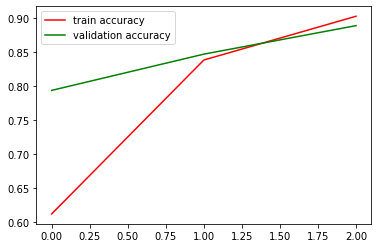

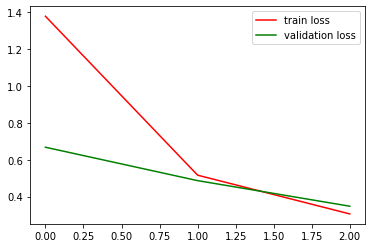

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss =  history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='train accuracy')
plt.plot(epochs, val_acc, 'g', label='validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='train loss')
plt.plot(epochs, val_loss, 'g', label='validation loss')
plt.legend()

plt.show()

### Wniosek
Model osiągnął dobry wynik (powyżej 90% dokładności) zarówno na zbiorze walidacyjnym jak i treningowym. Nie występuje problem przeuczenia się. Można zatem przystąpić do sprawdzenia jakości modelu na nieznanych mu danych testowych.

## Ewaluacja modelu na nowych danych 

In [11]:
test_scores = model.evaluate(test_gen, steps=test_steps)
test_scores

5417/5417 [==============================] - 54s 10ms/step - loss: 0.3453 - accuracy: 0.8911


[0.34527117013931274, 0.8910835981369019]

### Wniosek
Model jest stabilny, na zbiorze testowym osiągnął podobne wyniki jak na zbiorze walidacyjnym i treningowym (accuracy ok. 91%).
Sprawdźmy czy model posiada słabe strony, nad którymi można popracować w przyszłości.

## Macierz pomyłek

In [12]:
Y_pred = model.predict(test_gen)
y_pred = np.argmax(Y_pred, axis=1)

In [13]:
len(y_pred)

5417

In [14]:
len(test_gen.classes)

5417

In [15]:
conf_mat = confusion_matrix(test_gen.classes, y_pred)

In [16]:
# normalized
conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
conf_mat = np.around(conf_mat, decimals=2)

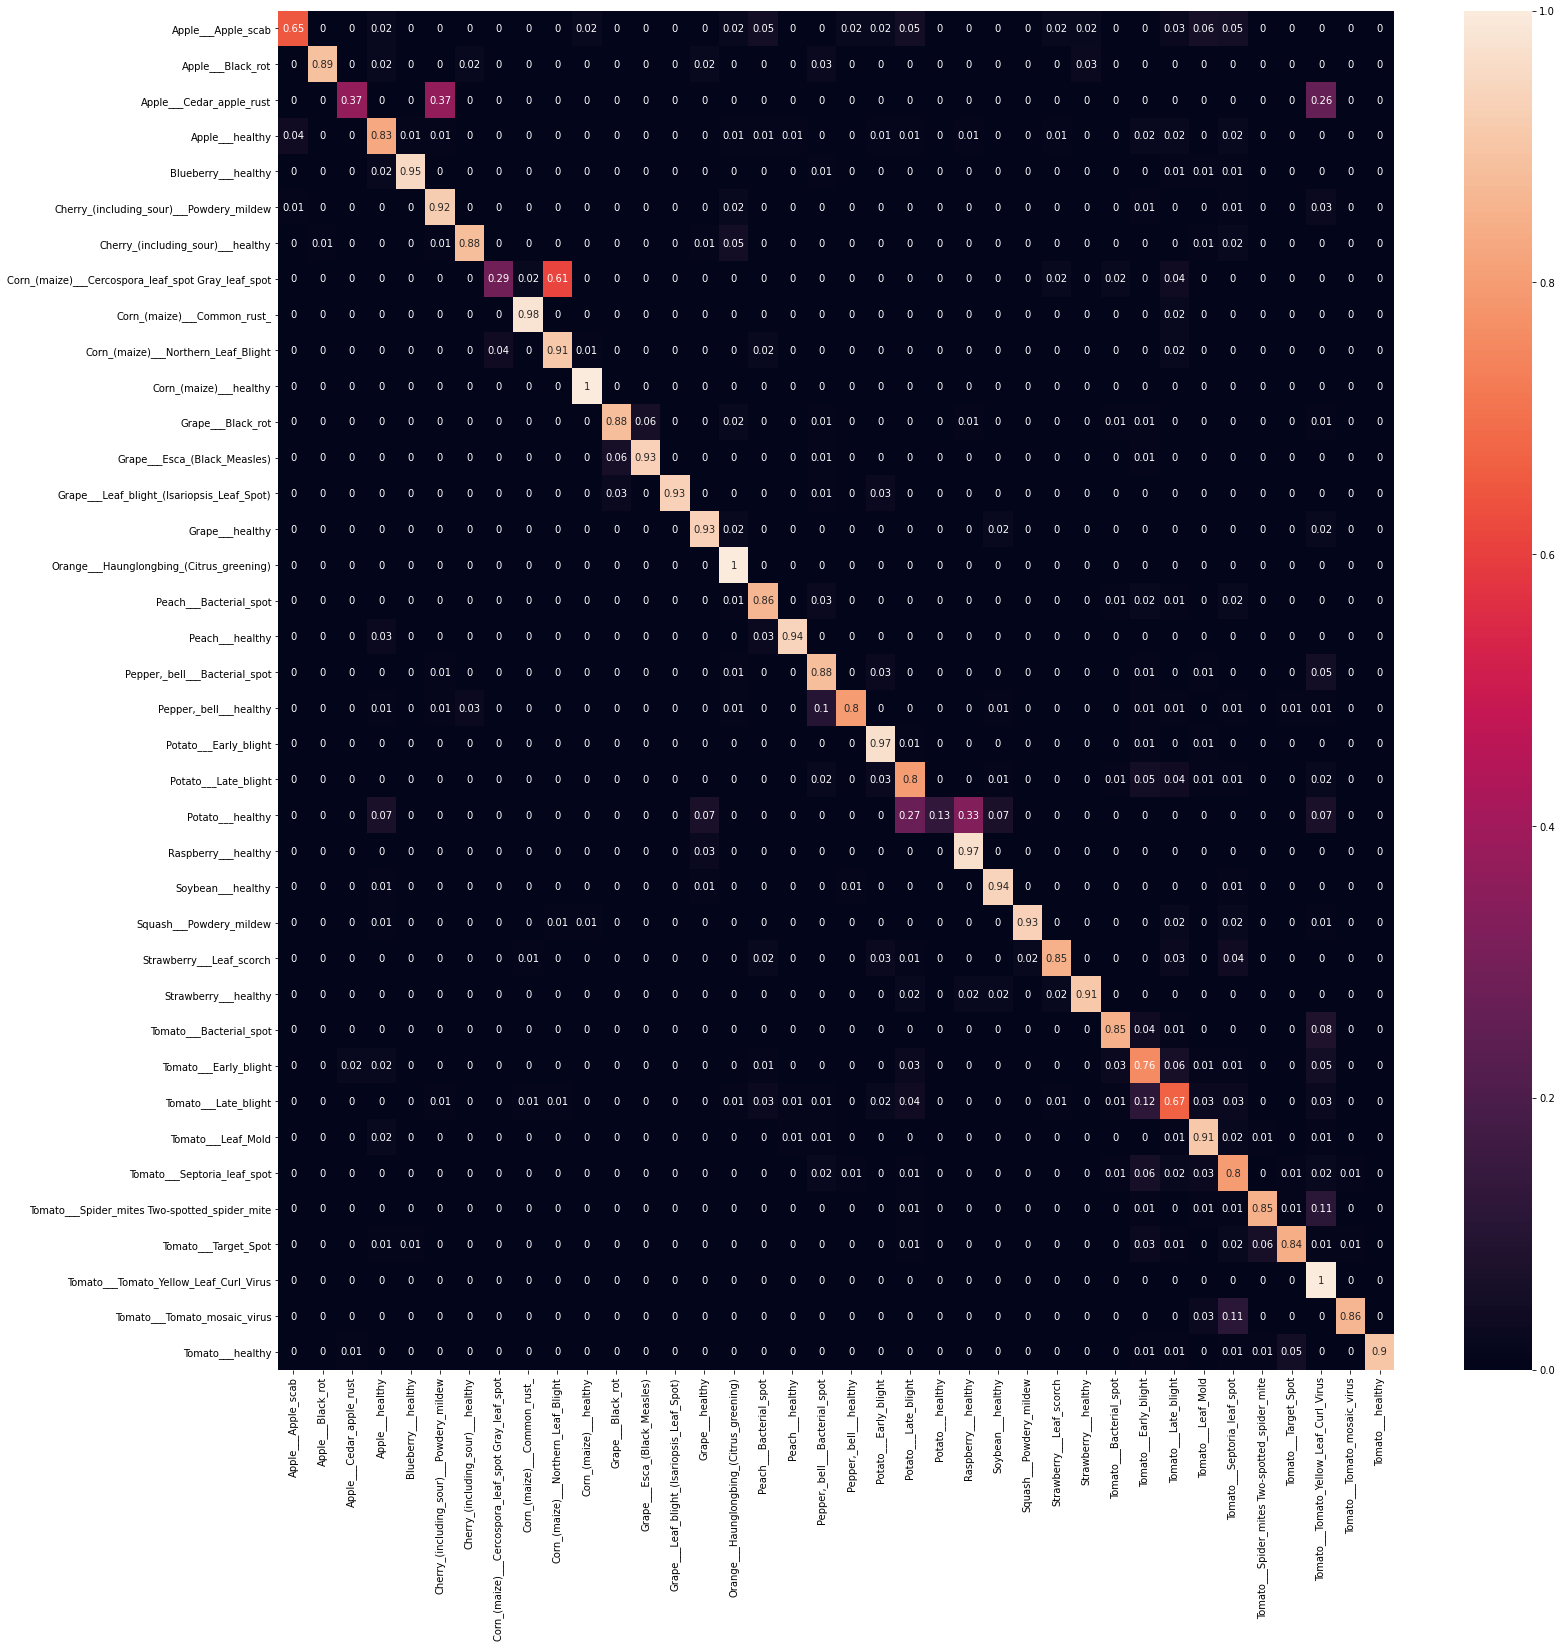

In [17]:
df_cm = pd.DataFrame(conf_mat, test_gen.class_indices.keys(), test_gen.class_indices.keys())
plt.figure(figsize=(25,25))
sns.heatmap(df_cm, annot=True)

plt.show()

### Wnioski
* Na podstawie macierzy pomyłek widać, że największym problemem dla modelu jest rozpoznawanie chorób kukurydzy, a w szczególności choroby Cercospora_leaf_spot Gray_leaf_spot. Tylko w 43% przypadków model rozpoznał chorobę, natomiast aż w 45% przypadków pomylił ją z chorobą Northern_Leaf_Blight. Być może warto byłoby wzbogacić zbiór danych o więcej zdjęć tych chorób.
* Ciekawe jest również to, że w 20% przypadków model pomylił zdrowego ziemniaka ze zdrową maliną.
* W 16% przypadków model pomylił zdrową truskawkę ze zdrową maliną.
* W pozostałych przypadkach nie występują większe problemy z poprawną klasyfikacją.

## Przykład klasyfikacji zdjęcia 

In [20]:
path = 'plants_2/plants_dataset_2/train/Tomato___Tomato_Yellow_Leaf_Curl_Virus/0b496439-e920-4d79-97dd-cfbbd491b895___UF.GRC_YLCV_Lab 01276.JPG'

img = image.load_img(path)

test_image = image.img_to_array(img)
test_image = np.expand_dims(test_image, axis=0)

model = keras.models.load_model('model3.h5')
pred = model.predict(test_image)
y_pred = np.argmax(pred, axis=1)

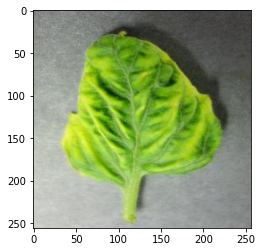

In [21]:
plt.imshow(img);

In [22]:
for k, v in test_gen.class_indices.items():
    if v == y_pred:
        print("actual: Tomato___Tomato_Yellow_Leaf_Curl_Virus", )
        print("prediction: ", k)

actual: Tomato___Tomato_Yellow_Leaf_Curl_Virus
prediction:  Tomato___Tomato_Yellow_Leaf_Curl_Virus


In [24]:
path = 'plants_2/plants_dataset_2/train/Orange___Haunglongbing_(Citrus_greening)/3d63b2a8-39bd-496c-8fec-0a85e9d5749f___CREC_HLB 5634.JPG'

img = image.load_img(path)

test_image = image.img_to_array(img)
test_image = np.expand_dims(test_image, axis=0)

pred = model.predict(test_image)
y_pred = np.argmax(pred, axis=1)

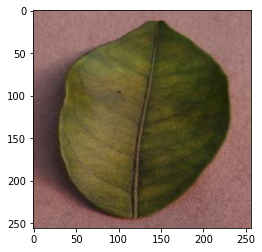

In [25]:
plt.imshow(img);

In [26]:
for k, v in test_gen.class_indices.items():
    if v == y_pred:
        print("actual: ", 'Orange___Haunglongbing_(Citrus_greening)')
        print("prediction: ", k)

actual:  Orange___Haunglongbing_(Citrus_greening)
prediction:  Orange___Haunglongbing_(Citrus_greening)


###  GPU

trzeba było zainstalować CUDA i cudnn ze stronki NVIDIA (for developers)

In [5]:
model = Sequential([
        Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(256, 256, 3)),
        MaxPool2D(pool_size=(2, 2)), 
        
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
                
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
    
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
    
        Flatten(),
        
        Dropout(0.2),
        
        Dense(128, activation='relu'),
        Dense(38, activation='softmax')
    ])

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       1

In [6]:
import tensorflow
print('GPU name: ', tensorflow.config.experimental.list_physical_devices('GPU'))

GPU name:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4665095204066765855
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2327314432
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12557481693460632626
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [9]:
!nvidia-smi

Tue Jun 29 16:39:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| N/A   42C    P8     3W /  N/A |   2858MiB /  3911MiB |     17%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [11]:
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory('plants_2/plants_dataset_2/train/', class_mode='categorical', batch_size=32)
val_gen = datagen.flow_from_directory('plants_2/plants_dataset_2/val/', class_mode='categorical', batch_size=32)
test_gen = datagen.flow_from_directory('plants_2/plants_dataset_2/test/', class_mode='categorical', batch_size=1, shuffle=False)

Found 37997 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.
Found 5417 images belonging to 38 classes.


In [12]:
train_steps = train_gen.n // train_gen.batch_size
val_steps = val_gen.n // val_gen.batch_size
test_steps = test_gen.n // test_gen.batch_size

In [13]:
%%time
history = model.fit(train_gen, steps_per_epoch=train_steps, epochs=3,
                    validation_data=val_gen, validation_steps=val_steps)

Epoch 1/3
1187/1187 [==============================] - 153s 128ms/step - loss: 1.2970 - accuracy: 0.6313 - val_loss: 0.6618 - val_accuracy: 0.7978
Epoch 2/3
1187/1187 [==============================] - 148s 125ms/step - loss: 0.4365 - accuracy: 0.8636 - val_loss: 0.3807 - val_accuracy: 0.8780
Epoch 3/3
1187/1187 [==============================] - 149s 125ms/step - loss: 0.2488 - accuracy: 0.9190 - val_loss: 0.2628 - val_accuracy: 0.9164
CPU times: user 8min 18s, sys: 15.1 s, total: 8min 33s
Wall time: 7min 30s


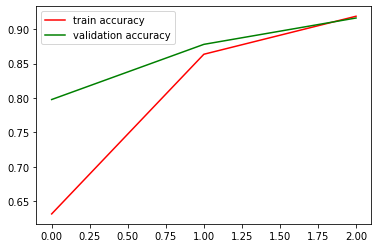

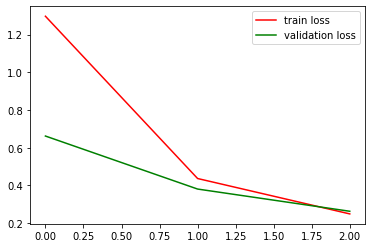

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss =  history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='train accuracy')
plt.plot(epochs, val_acc, 'g', label='validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='train loss')
plt.plot(epochs, val_loss, 'g', label='validation loss')
plt.legend()

plt.show()

In [15]:
test_scores = model.evaluate(test_gen, steps=test_steps)
test_scores

5417/5417 [==============================] - 12s 2ms/step - loss: 0.2545 - accuracy: 0.9215


[0.25451841950416565, 0.921543300151825]